In [2]:
import numpy as np
from numpy.linalg import matrix_power, matrix_rank
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import galois
from mec import make_circle
from scipy.sparse import csr_matrix
from scipy.stats import skew

In [38]:
codes = [
    [6,6,3,1,2,3,1,2],
    [15,3,9,1,2,0,2,7],
    [6,9,3,1,2,3,1,2],
    [6,12,3,1,2,3,1,2],
    [12,12,3,2,7,3,1,2],
    [30,6,9,1,2,3,25,26],
    [21,18,3,10,17,5,3,19]
]
code = codes[-2]

# 10,3,15,12,1,2,0,14,1,3,15,2,4,0.005,0.2,10001,9654,0.9653034696530348,3.8078865529319543,0.5207281650657156,8

# 10,6,30,27,5,4,3,29,28,6,30,2,1,0.005,0.1,10001,9810,0.9809019098090191,22,0.5983388736689147,12
# 10,6,30,21,1,2,3,13,26,6,30,2,2,0.005,0.1,10001,9799,0.9798020197980202,22,0.592000979396152,12


# code = [3,15,12,1,2,0,14,1,3,15,2,4]
# code = [6,30,21,1,2,3,13,26,6,30,2,2]
# code = [6,30,9,2,1,3,19,2,6,30,3,2]
# code = [6,30,27,5,4,3,29,28,6,30,2,1]
# code = [5,18,10,3,2,0,7,14,5,18,3,1]
# code = [3,12,9,2,1,3,10,5,3,12,3,3]

# code = [12,3,9,1,2,0,7,2,3,12,2,1] # working on this one
code = [12,3,9,1,2,0,7,2,3,12,2,0]
code = [12,3,9,1,2,0,1,11,3,12,2,0]

In [39]:
def cyclic_shift_matrix(l):
    arr = np.eye(l, dtype=int)
    return np.roll(arr, axis=1, shift=1)

ell = code[0]
m = code[1]

x = np.kron(cyclic_shift_matrix(ell), np.eye(m))
y = np.kron(np.eye(ell), cyclic_shift_matrix(m))

In [40]:
A1 = matrix_power(x, code[2])
A2 = matrix_power(y, code[3])
A3 = matrix_power(y, code[4])
A = ( A1 + A2 + A3 ) % 2

B1 = matrix_power(y, code[5])
B2 = matrix_power(x, code[6])
B3 = matrix_power(x, code[7])
B = ( B1 + B2 + B3 ) % 2

In [41]:
Hx = np.hstack([A, B]).astype(int)
Hz = np.hstack([B.T, A.T]).astype(int)
# H = np.vstack([Hx, Hz])

In [42]:
GF = galois.GF(2)
arr = GF(Hz.T)
print(f"k = {2 * (Hz.T.shape[1] - matrix_rank(arr))}")

k = 8


In [43]:
def has_toric_layout():
    # As = [A1 @ A2.T, A2 @ A3.T, A1 @ A3.T]  # A2 @ A3.T cycling up, A3 @ A2.T cycling up, etc.
    # Bs = [B1 @ B2.T, B2 @ B3.T, B1 @ B3.T]
    As = [A1 @ A2.T, A2 @ A1.T, A2 @ A3.T, A3 @ A2.T, A1 @ A3.T, A3 @ A1.T ]
    Bs = [B1 @ B2.T, B2 @ B1.T, B2 @ B3.T, B3 @ B2.T, B1 @ B3.T, B3 @ B1.T]


    def has_toric_layout1():
        def order(arr):
            for i in range(1, m*ell):
                if not np.any(np.eye(arr.shape[0]) - np.linalg.matrix_power(arr, i)):
                    return i
            return -1

        Aorders = [order(AA) for AA in As]
        Borders = [order(BB) for BB in Bs]

        pot_orders = []
        for i, Ao in enumerate(Aorders):
            for j, Bo in enumerate(Borders):
                if (Ao*Bo == m*ell):
                    pot_orders.append((Ao,Bo,i,j))
        return pot_orders

    def has_toric_layout2(pot_codes):
        emb_m, emb_ell, A_ind, B_ind = pot_codes

        visited_qbts = set()

        ver = csr_matrix(As[A_ind])
        hor = csr_matrix(Bs[B_ind])

        for i in range(emb_m):
            tmp_qbt = (ver**i)[0].indices[0] if i else 0
            for j in range(emb_ell):
                visited_qbts |= {(hor**j)[tmp_qbt].indices[0] if j else tmp_qbt}

        return len(visited_qbts) == ell*m

    confirmed_codes = []
    pot_codes = has_toric_layout1()
    for pot_code in pot_codes:
        if has_toric_layout2(pot_code):
            confirmed_codes.append(pot_code)
    return confirmed_codes

confirmed_codes = has_toric_layout()
print(confirmed_codes)

[(3, 12, 2, 0), (3, 12, 2, 1), (3, 12, 2, 4), (3, 12, 2, 5), (3, 12, 3, 0), (3, 12, 3, 1), (3, 12, 3, 4), (3, 12, 3, 5)]


In [44]:
def embed_code(code, init):
    emb_m, emb_ell, A_ind, B_ind = code

    lattice = np.empty((2*emb_m, 2*emb_ell), dtype=object)
    lattice[0][0] = f"x{init}"

    # As = [[A1, A2.T], [A2, A3.T], [A1, A3.T]]
    # Bs = [[B1, B2.T], [B2, B3.T], [B1, B3.T]]
    As = [[A1, A2.T], [A2, A1.T], [A2, A3.T], [A3, A2.T], [A1, A3.T], [A3, A1.T]]
    Bs = [[B1, B2.T], [B2, B1.T], [B2, B3.T], [B3, B2.T], [B1, B3.T], [B3, B1.T]]

    def get_nbr(i, j):
        if (i % 2 == 0):
            if (j % 2 == 0):
                return "x"
            else:
                return "r"
        else:
            if (j % 2 == 0):
                return "l"
            else:
                return "z"

    for i in range(2*emb_m - 1):
        for j in range(2*emb_ell):
            curr_ind = int(lattice[i][j][1:])

            if (i % 2 == 0):
                tmp_A = As[A_ind][1]
            else:
                tmp_A = As[A_ind][0]
            if (j % 2 == 0):
                tmp_B = Bs[B_ind][1]
            else:
                tmp_B = Bs[B_ind][0]

            lattice[(i+1)%(2*emb_m)][j] = f"{get_nbr((i+1)%(2*emb_m), j)}{np.where(tmp_A @ np.eye(m*ell)[curr_ind])[0][0]}"
            lattice[i][(j+1)%(2*emb_ell)] = f"{get_nbr(i, (j+1)%(2*emb_ell))}{np.where(tmp_B @ np.eye(m*ell)[curr_ind])[0][0]}"

    for i in range(2*emb_m):
        for j in range(2*emb_ell):
            if (lattice[i][j][0] == "z"):
                lattice[i][j] = f"z{int(lattice[i][j][1:]) + m*ell}"
            elif (lattice[i][j][0] == "r"):
                lattice[i][j] = f"r{int(lattice[i][j][1:]) + m*ell}"

    return lattice

In [45]:
for c,code in enumerate(confirmed_codes):
    lattice = embed_code(code, 0)

    colors = np.empty(lattice.shape, dtype=object)
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):
            if lattice[i][j][0] == "x":
                colors[i][j] = "red"
            elif lattice[i][j][0] == "r":
                colors[i][j] = "orange"
            elif lattice[i][j][0] == "l":
                colors[i][j] = "blue"
            else:
                colors[i][j] = "green"

    qbts = np.array([None for i in range(2*m*ell)])
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):
            if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
                qbts[int(lattice[i][j][1:])] = (i, j)

    x_rs = np.array([])
    for i in range(m*ell):
        gen_qbts = qbts[np.where(Hx[i])[0]]
        x_rs = np.append(x_rs, make_circle(gen_qbts)[2])
    # for i in range(m*ell):
    #     gen_qbts = qbts[np.where(Hz[i])[0]]
    #     rs.append(make_circle(gen_qbts)[2])

    x_mask = np.zeros(Hx.shape[0])
    for i, x in enumerate(x_rs):
        if (x > (min(x_rs))+np.std(x_rs)):
            x_mask[i] = 1
    p_mask = np.round(np.count_nonzero(x_mask)/(m*ell), 3)
    adv = (1-p_mask) / (sum(x_rs[x_mask==0])/sum(x_rs))

    print(c, code, adv)
    # scaled_rs = [(r - min(rs)) / (max(rs) - min(rs)) for r in rs]

    # bins = np.linspace(min(scaled_rs), max(scaled_rs), 20)
    # counts, _ = np.histogram(scaled_rs, bins=bins)
    # counts_weighter = counts.sum()

    # print(code, sum([x*y for x,y in zip(counts/counts_weighter, bins[:-1])]))
    # print(code, np.percentile(scaled_rs, 70))
    # plt.hist(bins[:-1], bins=bins, weights=counts/counts_weighter, label=f"{code}", alpha=0.7)
    # plt.legend()

0 (3, 12, 2, 0) 1.474967279404781
1 (3, 12, 2, 1) 1.6239641189593323
2 (3, 12, 2, 4) 1.4865351250932812
3 (3, 12, 2, 5) 1.4024536432881145
4 (3, 12, 3, 0) 1.474967279404781
5 (3, 12, 3, 1) 1.6239641189593323
6 (3, 12, 3, 4) 1.4865351250932812
7 (3, 12, 3, 5) 1.4024536432881145


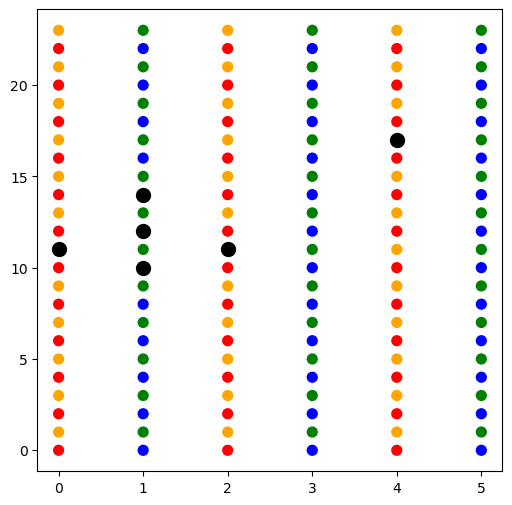

In [46]:
lattice = embed_code(confirmed_codes[0], 0)

colors = np.empty(lattice.shape, dtype=object)

for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "x":
            colors[i][j] = "red"
        elif lattice[i][j][0] == "r":
            colors[i][j] = "orange"
        elif lattice[i][j][0] == "l":
            colors[i][j] = "blue"
        else:
            colors[i][j] = "green"

qbts = np.array([None for i in range(2*m*ell)])
for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
            qbts[int(lattice[i][j][1:])] = (i, j)
x_checks = np.array([None for i in range(m*ell)])
z_checks = np.array([None for i in range(m*ell)])

for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "x":
            x_checks[int(lattice[i][j][1:])] = (i, j)
        elif lattice[i][j][0] == "z":
            z_checks[int(lattice[i][j][1:])-(m*ell)] = (i, j)



nodes = itertools.product(np.arange(lattice.shape[0]), np.arange(lattice.shape[1]))

gen_qbts = qbts[np.where(Hz[20])[0]] # 20x

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(*zip(*nodes), s=50, c=colors.flatten()) # vv qubits
ax.scatter(*zip(*gen_qbts), s=100, c='k')

4 0


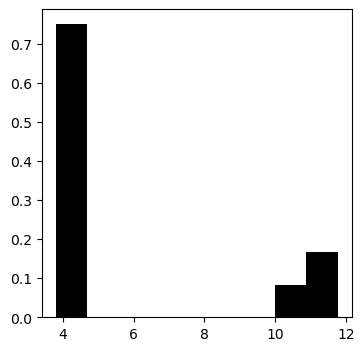

In [12]:
x_rs = []
z_rs = []
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    x_rs.append(make_circle(gen_qbts)[2])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    z_rs.append(make_circle(gen_qbts)[2])

fig, ax = plt.subplots(1, 1, figsize=(4,4))
rs = x_rs
bins = np.linspace(min(rs), max(rs), 10)
counts, _ = np.histogram(rs, bins=bins)
counts_weighter = counts.sum()
ax.hist(bins[:-1], bins=bins, weights=counts/counts_weighter, color='black')
print(np.argmin(rs), np.argmax(rs))

In [13]:
# for i in range(m*ell):
#     nlqbts = []
#     coord = x_checks[i]
#     gen_qbts = qbts[np.where(Hx[i])[0]]
#     for qbt in gen_qbts:
#         if (abs(coord[0]-qbt[0])+ abs(coord[1]-qbt[1]) > 1):
#             nlqbts.append(qbt)
#     if make_circle(gen_qbts)[2] < (min(x_rs)+np.std(x_rs)):
#         print([nlqbts, coord])

# for i in range(m*ell):
#     nlqbts = []
#     coord = z_checks[i]
#     gen_qbts = qbts[np.where(Hz[i])[0]]
#     for qbt in gen_qbts:
#         if (abs(coord[0]-qbt[0])+ abs(coord[1]-qbt[1]) > 1):
#             nlqbts.append(qbt)
#     if make_circle(gen_qbts)[2] < (min(z_rs)+np.std(z_rs)):
#         print([nlqbts, coord])

202.7187972119026
99.63915603485763
[11.7686023  11.52173913 11.52173913 11.00727032 11.         11.
 10.60660172 10.60660172 10.60660172]


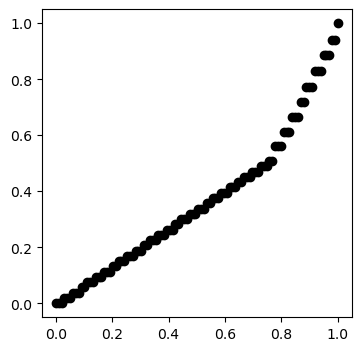

In [14]:
x_rs = np.array([])
z_rs = np.array([])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    x_rs = np.append(x_rs, make_circle(gen_qbts)[2])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    z_rs = np.append(z_rs, make_circle(gen_qbts)[2])

x_mask = np.zeros(Hx.shape[0])
for i, x in enumerate(x_rs):
    if (x > (min(x_rs))+np.std(x_rs)):
        x_mask[i] = 1
p_mask = np.round(np.count_nonzero(x_mask)/(m*ell), 3)
adv = (1 - p_mask) / (sum(x_rs[x_mask==1])/sum(x_rs))

# bins = np.linspace(min(rs), max(rs), 20)
# counts, _ = np.histogram(rs, bins=bins)
# counts_weighter = counts.sum()
# plt.hist(bins[:-1], bins=bins, weights=counts/counts_weighter)
print(sum(x_rs))
print(sum(x_rs[x_mask==1]))
print(x_rs[x_mask==1])

x_rs = sorted(x_rs)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
work = [sum((x_rs)[:int(i*len(x_rs))])/sum(x_rs) for i in np.linspace(0,1,100)]
plt.scatter(np.linspace(0,1,100), work, c='k')

In [15]:
arr = []
for i, x in enumerate(x_rs):
    if (x > (min(x_rs))+np.std(x_rs)):
        arr.append(i)
x_mask = np.zeros(Hx.shape[0]).astype(np.uint8)
x_mask[arr] = 1

Hxm = Hx[x_mask == 0]

print(arr)
print(len(arr)/Hx.shape[0])

arr = []
for i, z in enumerate(z_rs):
    if (z > (min(z_rs))+np.std(z_rs)):
        arr.append(i)

z_mask = np.zeros(Hz.shape[0]).astype(np.uint8)
z_mask[arr] = 1

Hzm = Hz[z_mask == 0]
print(arr)
print(len(arr)/Hz.shape[0])

[27, 28, 29, 30, 31, 32, 33, 34, 35]
0.25
[6, 7, 8, 21, 22, 23, 27, 28, 29]
0.25


In [150]:
arr = "90,16,15,3,0,1,2,3,14,11,3,15,2,4,0.267,1.5483219615844448"
arr = [[float(i) for i in arr.split(',')]]
col_names = ["n","k","ell","m","a1","a2","a3","b1","b2","b3","emb_m","emb_ell","aa","bb","p_mask","adv"]
df = pd.DataFrame(arr, columns=col_names)
df.iterrows()

<generator object DataFrame.iterrows at 0x000001AC059CD190>